<a href="https://colab.research.google.com/github/evanmacbride/microscope-autofocus/blob/main/notebooks/Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Workflow for Autofocusing Optical Microscope

This notebook provides a walkthrough of the machine learning workflow described in the paper "Autofocusing optical microscope using artificial neural network for large-area, high-magnification scanning" by Shizhao Lu and Evan MacBride. This project was prepared for the CHEG/CISC 867 course at the University of Delaware in Spring 2022. Our project mentor was Dr. Houk Jang of Brookhaven National Laboratory.

As a prerequisite to running this notebook, you will need access to a Google Drive directory of microscopy images with properly formatted filenames. A [directory of sample images](https://github.com/evanmacbride/microscope-autofocus/tree/main/sample_data/level1) can be copied from the GitHub repository for this project. 

You will need to make a small edit to the IMG_SRC_PATH variable set in the Data Preprocessing section. Change this variable to point to your Google Drive directory.

## Initial setup
Set up the Colab notebook for the machine learning workflow.

In [ ]:
# Import machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import *
from xgboost import XGBRegressor as xgb
from sklearn.ensemble import RandomForestRegressor as randomforest
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.linear_model import RidgeCV

# Import image processing and visualization utility libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy import ndimage

# Import file and visualization utility libraries
import concurrent.futures
from google.colab import drive
from imutils import paths
import re
import os
import zipfile

In [ ]:
# Perform some additional preliminary setup. You should see a pop-up prompting
# you to connect to your Google Drive. Click allow to connect. You must have a
# directory of microscopy images in your Drive. The image filenames must adhere
# to a naming standard described further below. You can get some sample images
# in the microscope-autofocus GitHub repository here:
# https://github.com/evanmacbride/microscope-autofocus/tree/main/sample_data/level1

# Mount Google Drive
drive.mount('/content/drive')
# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
# Check TensorFlow version
print("TensorFlow Version:",tf.__version__)

Mounted at /content/drive
TensorFlow Version: 2.8.0


In [ ]:
# Run nvidia-smi to ensure that our Colab session has a GPU. The output lists
# the GPU type and related information.
!nvidia-smi

Sat May  7 21:24:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Preprocessing
Perform edge detection by converting raw TIFF images to high pass filtered JPEGs. Set IMG_SRC_PATH equal to a directory of TIFF microscopy images.

In [ ]:
IMG_SRC_PATH = '/content/drive/MyDrive/data/sample_data/level1/'
JPEG_PATH = IMG_SRC_PATH + 'jpeg/'

In [ ]:
# Create a directory to save preprocessed images. Overwrite any existing
# directory of the same name.
!rm -rf $JPEG_PATH
!mkdir $JPEG_PATH

Source images found: 33
A sample raw image from the dataset:


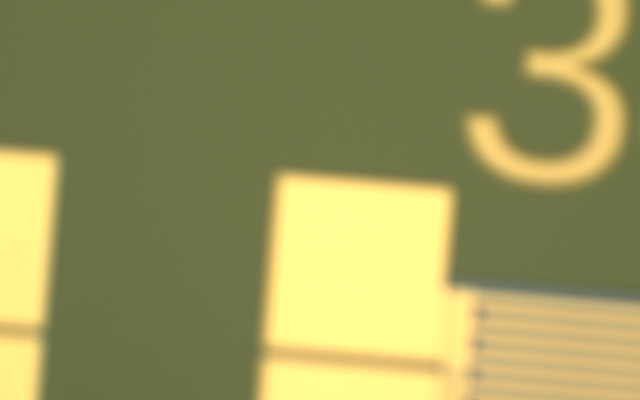

In [ ]:
src_img_paths = list(paths.list_files(IMG_SRC_PATH, validExts="tiff"))
print("Source images found:",len(src_img_paths))

# Display a sample raw image

print("A raw image from the dataset:")
img = cv2.imread(src_img_paths[0])
img_rsz = cv2.resize(img, (640,400),interpolation=cv2.INTER_AREA)
cv2_imshow(img_rsz)

In [ ]:
# Create JPEGs of high pass filtered images
kernel_size = 13
for img_path in src_img_paths:
    img = cv2.imread(img_path)
    # Apply the high pass filter
    hp_img = cv2.cvtColor(img - ndimage.gaussian_filter(img, kernel_size), 
                          cv2.COLOR_BGR2GRAY)
    src_bname = os.path.basename(img_path)
    src_fname, _ = os.path.splitext(src_bname)
    dest_fname = '{}{}.jpeg'.format(JPEG_PATH,src_fname)
    cv2.imwrite(dest_fname, hp_img)

A sample high pass filtered image (darker regions are flatter):


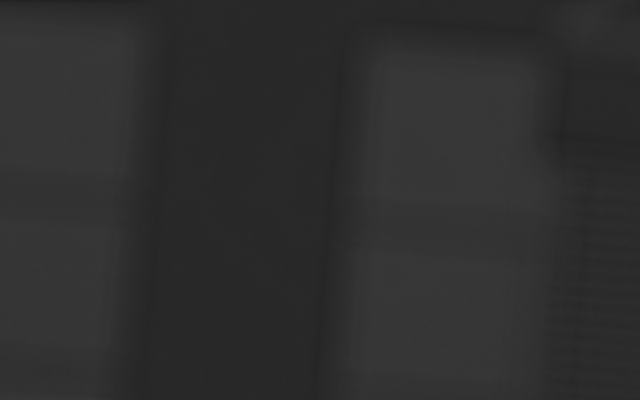

In [ ]:
hp_img_rsz = cv2.resize(hp_img, (640,400),interpolation=cv2.INTER_AREA)
print("A high pass filtered image (darker regions are flatter):")
cv2_imshow(hp_img_rsz)

Apply a threshold to sort image stacks above or below a given percentage of edge pixels respectively as "clean" or "noisy." Put a cap on maximum absolute distance to the focal plane. Labels and X and Y coordinates are extracted from the file names of input data. Filenames must adhere to the naming standard: ```<TITLE>_ix<X_COORD>_iy<Y_COORD>_<DIST_TO_FOCAL_PLANE>.<FILE_EXT>.``` For example, ```adjustedFocus_tile__ix010_iy011_3.5722075563708766.jpeg``` fits the standard. The image in this file would be labeled with distance 3.5722075563708766. It would be marked at coordinates (10,11). The images in the [sample_data folder](https://github.com/evanmacbride/microscope-autofocus/tree/main/sample_data/level1) of the GitHub repo adhere to this naming standard.

In [ ]:
# Specify image dimensions
img_height=1200
img_width=1920

# Image preprocessing utility function
def parse_images(img_path,height=img_height,width=img_width):
  '''Given an image path, height, and width, return a resized float32 of the image.'''
  img_file = tf.io.read_file(img_path)
  img_jpeg = tf.io.decode_jpeg(img_file, channels=3)
  img_flt = tf.image.convert_image_dtype(img_jpeg, tf.float32)
  img_rsz = tf.image.resize(img_flt, size=[height, width])

  return img_rsz

In [ ]:
# In debug mode, set JPEG_PATH to a directory of existing filtered images.
debug = False
if debug:
  JPEG_PATH = '/content/drive/MyDrive/data/level1_jpeg/'

In [ ]:
# Find the x and y coordinates of all images by parsing image filenames.

# Store image labels (i.e. distances to focal plane).
labels = []
# Store image positions. Each image stack will be at a set of X and Y 
# coordinates to be parsed from the filename.
all_coords = []

print("Extracting image coordinates from filenames...\n")

jpeg_img_paths = list(paths.list_files(JPEG_PATH, validExts="jpeg"))
for img_path in jpeg_img_paths:
  # Extract the image label from the filename
  img_bname = os.path.basename(img_path)
  img_fname, _ = os.path.splitext(img_bname)
  img_fname_split = re.split('_| ',img_fname)
  found_label = False
  tried_multiple = False
  for s in reversed(img_fname_split):
    try:
      label = np.abs(float(s))
      found_label = True
    except ValueError:
      print("Unable to parse filename {}. Tried to read {} as label.".format(img_bname,s))
      tried_multiple = True
      continue
    if found_label and tried_multiple:
      print("Found label:",s)
      break
    if found_label:
      break
  labels.append(label)
  # Extract the image coordinates from the filename
  coords = [c for c in img_path.split("_") if "ix" in c or "iy" in c]
  coor = "_".join(coords)
  all_coords.append(coor)
labels = np.array(labels)
all_coords = np.array(all_coords)
stack_total = len(set(all_coords))
print()
print("Total number of filtered images found:", len(jpeg_img_paths))
print("Unique image locations found:         ", stack_total)
print("Image stacks found:                   ", stack_total)

Extracting image coordinates from filenames...

Unable to parse filename adjustedFocus_tile__ix005_iy015_-15.166218758450722 (1).jpeg. Tried to read (1) as label.
Found label: -15.166218758450722
Unable to parse filename adjustedFocus_tile__ix005_iy015_-33.745665290158854 (1).jpeg. Tried to read (1) as label.
Found label: -33.745665290158854
Unable to parse filename adjustedFocus_tile__ix005_iy015_-38.518800564087485 (1).jpeg. Tried to read (1) as label.
Found label: -38.518800564087485
Unable to parse filename adjustedFocus_tile__ix014_iy000_-10.271774026431647 (1).jpeg. Tried to read (1) as label.
Found label: -10.271774026431647
Unable to parse filename adjustedFocus_tile__ix014_iy000_-11.532291924414794 (1).jpeg. Tried to read (1) as label.
Found label: -11.532291924414794
Unable to parse filename adjustedFocus_tile__ix014_iy000_-34.79015755973316 (1).jpeg. Tried to read (1) as label.
Found label: -34.79015755973316
Unable to parse filename adjustedFocus_tile__ix014_iy000_-4.195619

In [ ]:
# Save images as clean or discard as noisy. Evaluate the in-focus image in each
# image stack to determine if it's "clean" data or noise. If the in-focus image
# in a stack is clean, then the entire stack is clean.

# The filtered image pixel intensity required to consider a pixel to belong to
# an edge
intensity_thresh = 0.50
# Edge area percentage threshold (EAPT). The percentage of image edge pixels 
# required to consider the image "clean."
eap_thresh = 0.10

# In-focus image path positions in the list of image paths
infocus_img_pos = np.where(labels==0)[0]
# X/Y coordinate strings of physical locations of in-focus images
infocus_coords = all_coords[infocus_img_pos]
# Filenames for in-focus images
img_select = np.array(jpeg_img_paths)[infocus_img_pos]
edge_percentages = []
# Store X and Y coordinates of "clean" image stacks
clean_infocus_coords = []
#for img_path in img_select:
for img_path, pos in zip(img_select, infocus_coords):
  img_pixel_vals = parse_images(img_path)[:,:,0]
  pixels_above_threshold = len(np.where(img_pixel_vals >= 
                                        intensity_thresh)[0])
  edge_percentage = pixels_above_threshold / img_height / img_width
  edge_percentages.append(edge_percentage)
  if edge_percentage >= eap_thresh:
    clean_infocus_coords.append(pos)
print("Clean image stacks found:",len(clean_infocus_coords))

Clean image stacks found: 108


In [ ]:
# After finding which in-focus images are clean, find the other images in the
# clean image stacks and save them as clean as well.

clean_stack_pos_list = []
for cs in clean_infocus_coords:
  clean_position = np.where(all_coords==cs)[0]
  for pos in clean_position:
    clean_stack_pos_list.append(pos)

jpeg_imgs_select = np.array(jpeg_img_paths)
clean_paths = jpeg_imgs_select[clean_stack_pos_list]
print("Total number of clean images found:",len(clean_paths))

Total number of clean images found: 1186


A clean, in-focus image.
Filename: /content/drive/MyDrive/data/level1_jpeg/adjustedFocus_tile__ix005_iy001_0.jpeg


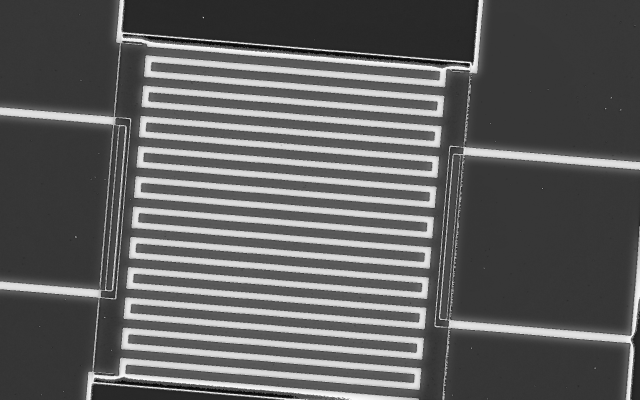

In [ ]:
# Display an example clean, in-focus image
clean_example = clean_paths[5]
img = cv2.imread(clean_example)
img_rsz = cv2.resize(img, (640,400),interpolation=cv2.INTER_AREA)
print("A clean, in-focus image.")
print("Filename:",clean_example)
cv2_imshow(img_rsz)

In [ ]:
# Now put a cap on the maximum allowable distance to the focal plane. Reject
# images that are at a distance above this cap.

# The cap on an image's allowable maximum absolute distance to the focal plane
cap = 20

clean_labels = labels[clean_stack_pos_list]

# not include the focal distance larger than cap
capped_clean_labels = clean_labels[np.where(np.abs(clean_labels)<=cap)[0]]
capped_clean_paths = clean_paths[np.where(np.abs(clean_labels)<=cap)[0]]

print("Number of clean images below the focal distance cap:",len(capped_clean_labels))

Number of clean images below the focal distance cap: 510


## Feature Extraction
Extract feature map representations of training images from a pre-trained convolutional neural network (CNN). First, initiate the CNN model.

In [ ]:
# Get the Resnet50 model and use its weights to extract image features
Resnet50_transfer = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height, img_width, 3), 
    pooling=None,
)

Resnet50_transfer.trainable = True

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
Resnet50_transfer.trainable = False

supervise_model = tf.keras.models.Sequential([
    Resnet50_transfer,
    GlobalAveragePooling2D(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [ ]:
# Redefine parse_images with TensorFlow's @tf.function decorator.
@tf.function
def parse_images(img_path,height=img_height,width=img_width):
  '''Given an image path, height, and width, return a resized float32 of the image.'''
  img_file = tf.io.read_file(img_path)
  img_jpeg = tf.io.decode_jpeg(img_file, channels=3)
  img_flt = tf.image.convert_image_dtype(img_jpeg, tf.float32)
  img_rsz = tf.image.resize(img_flt, size=[height, width])

  return img_rsz

In [ ]:
# Extract features from the pretrained CNN in segments to avoid an out-of-memory 
# problem. Google Colab runs out of memory when given an image set size larger 
# than 1000.
chunk_size = 500
n_segments = len(capped_clean_paths) // chunk_size + 1
# Only one image is sent through the CNN at a time. We aren't retraining the
# model. We're only interested in extracting the model's condensed internal 
# representation of individual images (i.e. feature maps).
training_batch_size = 1
feature_extractor = Model(supervise_model.input, supervise_model.layers[-4].output)

for i in range(n_segments):
  if i == 0:
    train_ds = tf.data.Dataset.from_tensor_slices(capped_clean_paths[:(i+1)*chunk_size])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    features = feature_extractor.predict(train_ds)

  else:
    train_ds = tf.data.Dataset.from_tensor_slices(
        capped_clean_paths[i*chunk_size:(i+1)*chunk_size])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    features = np.append(features, feature_extractor.predict(train_ds), axis=0)

## K-Fold Cross Validation
Collect performance metrics for multiple regression models, each run several times on k-fold splits of the data. Compare differences when models are trained on different sized datasets.

In [ ]:
training_data_size = np.array([10, 20, 50, 80, 100, 150, 200])
n_folds = 5
n_split_split = 5
n_validation_images = 50
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_split_split, random_state=42)

xgb_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
ridge_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
rf_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
mlp_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))

k = 0
for train_ix, test_ix in rkf.split(features, capped_clean_labels):
      print("K Fold:",k)
      Train_feature, val_feature = features[train_ix], features[test_ix]
      Train_label, val_label = capped_clean_labels[train_ix], capped_clean_labels[test_ix]
      val_feature = val_feature[:n_validation_images]
      val_label = val_label[:n_validation_images]
      
      for i in range(len(training_data_size)):
        print("Training with dataset size:",training_data_size[i])
        # initate regressors
        mlp_regressor = mlp(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
        ridge_regressor = RidgeCV()
        xg_boost_regressor = xgb(max_depth=16, learning_rate=0.1, 
                                 tree_method='gpu_hist', 
                                 objective='reg:squarederror')
        # Colab may crash from OOM if max_depth is set greater than 16.
        rf_regressor = randomforest(max_depth=16)
        
        train_feature = Train_feature[:training_data_size[i]]
        train_label = Train_label[:training_data_size[i]]

        mlp_regressor.fit(train_feature, train_label)
        y_pred_mlp = mlp_regressor.predict(val_feature)
        mlp_scores[i, k, 0] = r2_score(y_pred_mlp, val_label)
        mlp_scores[i, k, 1] = mean_absolute_error(y_pred_mlp, val_label)  

        ridge_regressor.fit(train_feature, train_label)
        y_pred_ridge = ridge_regressor.predict(val_feature)
        ridge_scores[i, k, 0] = r2_score(y_pred_ridge, val_label)
        ridge_scores[i, k, 1] = mean_absolute_error(y_pred_ridge, val_label)

        xg_boost_regressor.fit(train_feature, train_label)
        y_pred_xgb = xg_boost_regressor.predict(val_feature)
        xgb_scores[i, k, 0] = r2_score(y_pred_xgb, val_label)
        xgb_scores[i, k, 1] = mean_absolute_error(y_pred_xgb, val_label)

        rf_regressor.fit(train_feature, train_label)
        y_pred_rf = rf_regressor.predict(val_feature)
        rf_scores[i, k, 0] = r2_score(y_pred_rf, val_label)
        rf_scores[i, k, 1] = mean_absolute_error(y_pred_rf, val_label)
        
      k += 1

K Fold: 0
Training with dataset size: 10
Training with dataset size: 20
Training with dataset size: 50
Training with dataset size: 80
Training with dataset size: 100
Training with dataset size: 150
Training with dataset size: 200
K Fold: 1
Training with dataset size: 10
Training with dataset size: 20
Training with dataset size: 50
Training with dataset size: 80
Training with dataset size: 100
Training with dataset size: 150
Training with dataset size: 200
K Fold: 2
Training with dataset size: 10
Training with dataset size: 20
Training with dataset size: 50
Training with dataset size: 80
Training with dataset size: 100
Training with dataset size: 150
Training with dataset size: 200
K Fold: 3
Training with dataset size: 10
Training with dataset size: 20
Training with dataset size: 50
Training with dataset size: 80
Training with dataset size: 100
Training with dataset size: 150
Training with dataset size: 200
K Fold: 4
Training with dataset size: 10
Training with dataset size: 20
Training

## Results
Compare the R2 scores and mean absolute error (MAE) of the different regression models.

In [ ]:
for i in range(len(training_data_size)):
  print('training_data_size: %i' % training_data_size[i])
  print("XGBoost Metrics:")
  print()
  print("Mean R2:    ",np.average(xgb_scores[i, :, 0]))
  print("Std Dev R2: ",np.std(xgb_scores[i, :, 0]))
  print("Mean MAE:   ",np.average(xgb_scores[i, :, 1]))
  print("Std Dev MAE:",np.std(xgb_scores[i, :, 1]))
  print()

  print("Ridge Metrics:")
  print()
  print("Mean R2:    ",np.average(ridge_scores[i, :, 0]))
  print("Std Dev R2: ",np.std(ridge_scores[i, :, 0]))
  print("Mean MAE:   ",np.average(ridge_scores[i, :, 1]))
  print("Std Dev MAE:",np.std(ridge_scores[i, :, 1]))
  print()
  
  print("Multilayer Perceptron Metrics:")
  print()
  print("Mean R2:    ",np.average(mlp_scores[i, :, 0]))
  print("Std Dev R2: ",np.std(mlp_scores[i, :, 0]))
  print("Mean MAE:   ",np.average(mlp_scores[i, :, 1]))
  print("Std Dev MAE:",np.std(mlp_scores[i, :, 1]))
  print()
  
  print("Random Forest Metrics:")
  print()
  print("Mean R2:    ",np.average(rf_scores[i, :, 0]))
  print("Std Dev R2: ",np.std(rf_scores[i, :, 0]))
  print("Mean MAE:   ",np.average(rf_scores[i, :, 1]))
  print("Std Dev MAE:",np.std(rf_scores[i, :, 1]))
  print()

training_data_size: 10
XGBoost Metrics:

Mean R2:     0.5723378066492248
Std Dev R2:  0.1703355106231386
Mean MAE:    2.6940328264694613
Std Dev MAE: 0.4422746665533791

Ridge Metrics:

Mean R2:     0.7056525371790281
Std Dev R2:  0.169047597830713
Mean MAE:    2.1742239269180237
Std Dev MAE: 0.33899755270785553

Multilayer Perceptron Metrics:

Mean R2:     0.8196974533276077
Std Dev R2:  0.04215516644793967
Mean MAE:    1.8027179132284874
Std Dev MAE: 0.24940628971958193

Random Forest Metrics:

Mean R2:     0.2523720887668624
Std Dev R2:  0.3934189288871037
Mean MAE:    2.8872523938180343
Std Dev MAE: 0.3813983987695437

training_data_size: 20
XGBoost Metrics:

Mean R2:     0.7614321279352555
Std Dev R2:  0.1282651595038013
Mean MAE:    1.991547018831715
Std Dev MAE: 0.4255874514900408

Ridge Metrics:

Mean R2:     0.8534695284326712
Std Dev R2:  0.06843485198682174
Mean MAE:    1.7705203102149054
Std Dev MAE: 0.25600646155947626

Multilayer Perceptron Metrics:

Mean R2:     0.901501

## Prediction Plots
Plot the predicted vs. actual distance for the different models.

Random Forest prediction R2 Score = 0.973726
Random Forest prediction MAE = 0.724060


Text(0, 0.5, 'predicted_distance [$\\mu m$]')

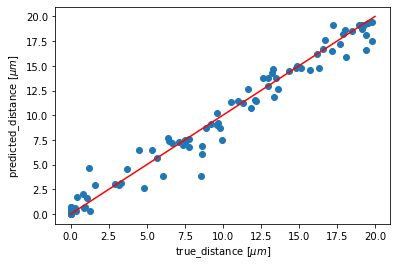

In [ ]:
features_train, features_test, train_label, test_label = train_test_split(features, capped_clean_labels, test_size=0.2, random_state=42)
y_pred_rf = rf_regressor.predict(features_test)

print('Random Forest prediction R2 Score = %f' % r2_score(y_pred_rf, test_label))
print('Random Forest prediction MAE = %f' % mean_absolute_error(y_pred_rf, test_label))
plt.scatter(test_label, y_pred_rf)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance [$\mu m$]')
plt.ylabel('predicted_distance [$\mu m$]')

RidgeCV prediction R2 = 0.964678
RidgeCV prediction MAE = 0.995972


Text(0, 0.5, 'predicted_distance')

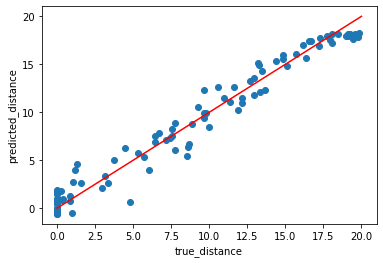

In [ ]:
y_pred_ridge = ridge_regressor.predict(features_test)

print('RidgeCV prediction R2 = %f' % r2_score(y_pred_ridge, test_label))
print('RidgeCV prediction MAE = %f' % mean_absolute_error(y_pred_ridge, test_label))
plt.scatter(test_label, y_pred_ridge)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')

MLP prediction R2 = 0.946523
MLP prediction MAE = 1.150062


Text(0, 0.5, 'predicted_distance')

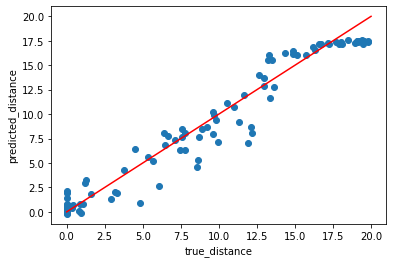

In [ ]:
y_pred_mlp = mlp_regressor.predict(features_test)

print('MLP prediction R2 = %f' % r2_score(y_pred_mlp, test_label))
print('MLP prediction MAE = %f' % mean_absolute_error(y_pred_mlp, test_label))
plt.scatter(test_label, y_pred_mlp)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')

XGBoost prediction R2 = 0.971900
XGBoost prediction MAE = 0.661729


Text(0, 0.5, 'predicted_distance')

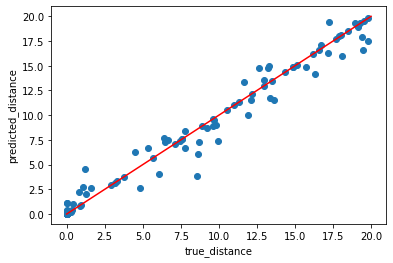

In [ ]:
y_pred_xgb = xg_boost_regressor.predict(features_test)

print('XGBoost prediction R2 = %f' % r2_score(y_pred_xgb, test_label))
print('XGBoost prediction MAE = %f' % mean_absolute_error(y_pred_xgb, test_label))
plt.scatter(test_label, y_pred_xgb)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')